Bahdanau Attention

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class AttentionDecoder(d2l.Decoder):
    """Basic interface of decoder with attention mechanism"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [3]:
class Seq2SeqEncoder(d2l.Encoder):
    """Seq2Seq RNN Encoder"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size) # Embedding operation
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout) # Gated Recurrent Unit (GRU)

    def forward(self, X, *args):
        X = self.embedding(X) # Embed inputs
        X = X.permute(1, 0, 2) # Sort parameters
        output, state = self.rnn(X) # Get prediction of GRU
        return output, state

In [4]:
class Seq2SeqDecoder(d2l.Decoder):
    """Seq2Seq RNN Decoder"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, # Embed size from decoder + Hidden layers from encoder
            num_hiddens, 
            num_layers,
            dropout=dropout
        )
        self.dense = nn.Linear(num_hiddens, vocab_size) # Output layer: in_features = num_hiddens, out_features = vocab_size

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1] # output, state = enc_outputs[0], enc_outputs[1]
        # It returns state here from encoder

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        context = state[-1].repeat(X.shape[0], 1, 1) # state[-1] = In the last time step and last layer, state = All hidden states of RNN in the last time step
        X_and_context = torch.cat((X, context), 2) # dim = 2
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2) # batch size = 1
        return output, state

In [7]:
"""Attention mechanism should only be applied in decoder"""
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(
            self,
            vocab_size,
            embed_size,
            num_hiddens,
            num_layers,
            dropout=0,
            **kwargs
        ):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        # permute(batch_size, sequence_length, hidden_states)
        # enc_valid_lens = ensure how long sequence length should be padded
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X: # seq2seq prediction = step by step
            # X = the input of decoder
            query = torch.unsqueeze(
                hidden_state[-1], # the output of RNN (encoder) in the last time step
                dim=1 # Add the dimension (number of queries)
            )
            context = self.attention(
                query,         # query
                enc_outputs,   # key
                enc_outputs,   # value
                enc_valid_lens # used to ignore unnecessary texts (words) (attention focus mechanism)
            )
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1) # concatenate embedded x and context
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state) # put embedded x and context into RNN
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [8]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

In [10]:
def sequence_mask(X, valid_len, value=0):
    """Disable unrelated items in sequence"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """Masked softmax cross entropy loss function"""
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train Seq2Seq model"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            # Y_hat, _ = net(X, dec_input, X_valid_len) # ValueError (expected 2)
            Y_hat = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.020, 6985.7 tokens/sec on cuda:0


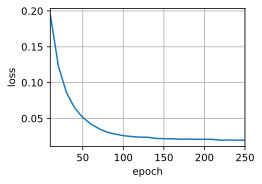

In [11]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
# d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [12]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, 
        eng, 
        src_vocab, 
        tgt_vocab, 
        num_steps, 
        device, 
        True
    )
    print(f'{eng} => {translation}, ', f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [13]:
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weight_seq],
    0
    ).reshape(
        (1, 1, -1, num_steps)
    )

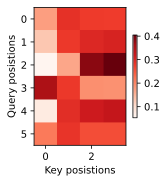

In [14]:
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key posistions', ylabel='Query posistions'
)